In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from uncprop.models.vsem.runner import run_vsem_experiment
from uncprop.utils.plot import set_plot_theme

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from uncprop.utils.grid import Grid

def summarize_rep(out_dir: str | Path, subdir_name: str, rep_idx: int, n_reps: int):
    subdir = Path(out_dir) / subdir_name
    info_path = subdir / 'logging_info.npz'

    # check if rep failed
    info = jnp.load(subdir / 'logging_info.npz')
    failed_reps = info['failed_reps']
    if rep_idx in failed_reps:
        print(f'Replicate {rep_idx} failed.')
        return None
    
    # adjust rep index (necessary if some reps failed)
    if len(failed_reps) > 0:
        all_rep_idx = [idx for idx in range(n_reps)]
        rep_idx = all_rep_idx.index(rep_idx)
    
    # Load grid for plots
    grid_info = jnp.load(subdir / 'grid_info.npz')

    grid = Grid(low=grid_info['low'],
                high=grid_info['high'],
                n_points_per_dim=grid_info['n_points_per_dim'],
                dim_names=grid_info['dim_names'])
    
    # load results
    results = jnp.load(subdir / 'results.npz')
    
    return grid, results

In [3]:
out_dir = base_dir / 'out' / 'vsem'
subdir_name = 'clip_gp_N4'
rep_idx = 4

grid, results = summarize_rep(out_dir=out_dir,
                              subdir_name=subdir_name,
                              rep_idx=rep_idx,
                              n_reps=100)



In [8]:
for r in results.keys():
    print(r)

vsem_params
driver
vsem_output
observable
observation
pred_mean
pred_var
design_x
design_y
log_dens_approx
log_coverage
probs
dist_names
vsem_param_names


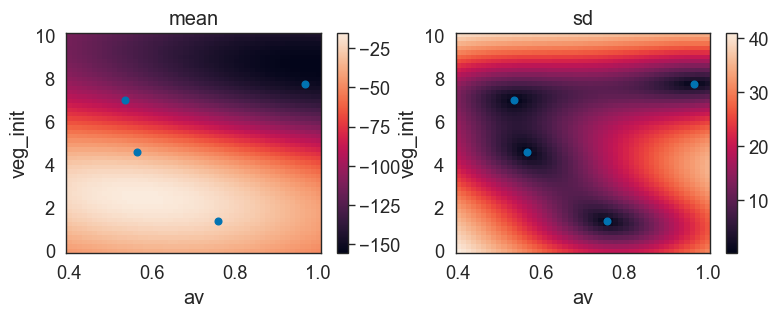

In [7]:
pred_mean = results['pred_mean'][rep_idx]
pred_sd = jnp.sqrt(results['pred_var'])[rep_idx]
design_x = results['design_x'][rep_idx]

fig, ax = grid.plot(z=[pred_mean, pred_sd],
                    titles=['mean', 'sd'],
                    points=design_x,  max_cols=3)

In [ ]:
for key in results.keys():
    print(key)

In [ ]:
out_dir = base_dir / 'out' / 'vsem'
subdirs = ['clip_gp_N4', 'clip_gp_N8', 'clip_gp_N16', 'gp_N4', 'gp_N8', 'gp_N16']

for subdir in subdirs:
    jnp.savez(out_dir / subdir / 'grid_info.npz', 
            low=grid_info['low'],
            high=grid_info['high'],
            n_points_per_dim=grid_info['n_points_per_dim'],
            dim_names=grid_info['dim_names'])

In [ ]:
base_out_dir = base_dir / 'out' / 'vsem_old'
grid_info = jnp.load(base_out_dir / 'grid.npz')

In [ ]:
grid_info['dim_names']

In [ ]:
from uncprop.utils.grid import Grid

base_out_dir = base_dir / 'out' / 'vsem'
grid_info = jnp.load(base_out_dir / 'grid.npz')

grid = Grid(low=grid_info['low'],
            high=grid_info['high'],
            n_points_per_dim=grid_info['n_points_per_dim'],
            dim_names=grid_info['dim_names'])


In [ ]:
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')
out_dir = base_dir / 'out' / 'vsem' / 'clip_gp_N4'

info = jnp.load(out_dir / 'logging_info.npz')
failed_reps = info['failed_reps']

results = jnp.load(out_dir / 'results.npz')
print(results)

In [ ]:
rep_idx = 4

grid.plot(z=results['pred_mean'][rep_idx])

In [ ]:
results, failed_iters = test
print(failed_iters)
print(len(results))

In [ ]:
results[4].surrogate_pred.cov

In [ ]:
from uncprop.models.vsem.experiment import VSEMReplicate

key = jr.key(9768565)
rep = VSEMReplicate(key=key,
                    n_design=8,
                    noise_sd=1.0,
                    n_grid=50,
                    jitter=1e-4)

In [ ]:
from uncprop.models.vsem.experiment import VSEMExperiment, VSEMReplicate

key = jr.key(9768565)
setup_kwargs = {'n_grid': 50, 
                'n_design': 8, 
                'noise_sd': 1.0, 
                'verbose': False,
                'jitter': 1e-4}
num_reps = 20
backup_frequency = 10
experiment_name = 'vsem'
out_dir = base_dir / 'temp_out' / experiment_name

def _make_subdir_name(setup_kwargs, run_kwargs):
    return f'{run_kwargs['surrogate_tag']}_N{setup_kwargs['n_design']}'

# -----------------------------------------------------------------------------
# Run experiment 
# -----------------------------------------------------------------------------
experiment = VSEMExperiment(name=experiment_name,
                            num_reps=8, 
                            base_out_dir=out_dir,
                            base_key=key,
                            Replicate=VSEMReplicate,
                            subdir_name_fn=_make_subdir_name,
                            write_to_file=False)


In [ ]:
test = experiment(run_kwargs={'surrogate_tag': 'clip_gp'}, 
                  setup_kwargs=setup_kwargs, 
                  backup_frequency=2)

In [ ]:
results, failed_iters = test

print(failed_iters)

In [ ]:
test = experiment.collect_results(results, failed_iters)

In [ ]:
results, failed_iters = run_vsem_experiment()

In [ ]:
from uncprop.utils.grid import _is_normalized

for idx, rep in enumerate(results):
    for nm in ['exact', 'mean', 'eup', 'ep']:
        l = rep.density_comparison.log_dens_norm_grid[nm]
        is_inf = jnp.isinf(l)
        is_norm = _is_normalized(l)
        if jnp.any(jnp.logical_or(is_inf, ~is_norm)):
            print(f'{idx} - {nm}')

In [ ]:
rep = results[15]
l = rep.density_comparison.log_dens_grid['ep']

l

In [ ]:
flat_grid = rep.density_comparison.grid.flat_grid

gp = rep.surrogate_posterior_gp.posterior_surrogate.surrogate
pred = gp(flat_grid)

In [ ]:
from jax.numpy.linalg import cholesky
from jax.lax.linalg import cholesky as cholesky_lax

d = pred.dim
C = pred.cov.at[jnp.diag_indices(d)].add(1e-3)

L = cholesky(C, upper=False)
L2 = cholesky_lax(C, symmetrize_input=True)

print(f'jnp: {jnp.sum(jnp.isnan(L))}')
print(f'lax: {jnp.sum(jnp.isnan(L2))}')

In [ ]:
from uncprop.models.vsem.surrogate import _print_gp_fit_info

_print_gp_fit_info(gp.gp, rep.fit_info)

In [ ]:
rep.posterior.prior.support

In [ ]:
# coverage results
log_coverage = jnp.stack(
    [rep.density_comparison.calc_coverage(baseline='exact')[0] for rep in results],
    axis=0
)

In [ ]:
key = jr.key(9768565)
setup_kwargs = {'n_grid': 50, 'n_design': 4, 'noise_sd': 1.0, 'verbose': False}
num_reps = 3
experiment_name = 'vsem'
out_dir = base_dir / 'out' / experiment_name

# 3 cases: n = 4, 8, and one other (maybe 16)

def _make_subdir_name(setup_kwargs, run_kwargs):
    return f'{run_kwargs['surrogate_tag']}_N{setup_kwargs['n_design']}'

experiment = Experiment(name=experiment_name,
                        num_reps=num_reps,
                        base_out_dir=out_dir,
                        base_key=key,
                        Replicate=VSEMReplicate,
                        subdir_name_fn=_make_subdir_name)

# results_gp, failed_iters_gp = experiment(run_kwargs={'surrogate_tag': 'gp'}, 
#                                          setup_kwargs=setup_kwargs)

results_clip_gp, failed_iters_clip_gp = experiment(run_kwargs={'surrogate_tag': 'clip_gp'}, 
                                                   setup_kwargs=setup_kwargs)

In [ ]:
for rep in results_gp:
    rep.density_comparison.plot(normalized=True, log_scale=False,
                                max_cols=4, points=rep.surrogate_posterior_gp.surrogate.design.X)
    rep.density_comparison.plot_coverage(baseline='exact')

In [ ]:
for rep in results_clip_gp:
    rep.density_comparison.plot(normalized=True, log_scale=False,
                                max_cols=4, points=rep.surrogate_posterior_clip_gp.surrogate.design.X)
    rep.density_comparison.plot_coverage(baseline='exact')

In [ ]:
from uncprop.utils.grid import plot_coverage_curve_reps

log_coverage_reps = jnp.stack(
    [rep.density_comparison.calc_coverage(baseline='exact')[0] for rep in results_clip_gp],
    axis=0
)

probs = results_clip_gp[0].density_comparison.calc_coverage(baseline='exact')[1]

fig, ax = plot_coverage_curve_reps(log_coverage_reps, probs=probs, names=['mean', 'eup', 'ep'])

In [ ]:
# summarize surrogate mean and sd
pred = surrogate_posterior.surrogate(grid.flat_grid)

grid.plot(z=pred.mean, title='surrogate mean', points=design.X)
grid.plot(z=jnp.sqrt(pred.variance), title='surrogate sd', points=design.X)

In [ ]:
# sampling posterior
key, key_mcmc = jr.split(key, 2)

samp = posterior.sample(key, n=3000, num_warmup_steps=500) # returns HMCState with samp.position (n, 1, 2)

plt.hist(samples[:,0])
plt.show()

In [ ]:
density_comparison.plot(['exact', 'mean', 'eup', 'ep'],
                         normalized=True, log_scale=False,
                         max_cols=4, points=design.X)

In [ ]:
from uncprop.utils.grid import get_grid_coverage_mask, plot_2d_mask

mask = get_grid_coverage_mask(log_prob=density_comparison.log_dens_norm_grid['ep'],
                              probs=jnp.linspace(0.1, 0.9, 30))

fig, ax = plot_2d_mask(mask, grid.shape, prob_idx=[0, 15, 20])

# TEMP

In [ ]:
import blackjax

In [ ]:
mwg_init_x = blackjax.rmh.init